Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import f_oneway

# Get data

In [2]:
filename = '110524.csv'

dfin = pd.read_csv(filename)
#encode gender as a 0/1
df = pd.get_dummies(dfin, columns=['gender'])
#store the language labels separately
langdata = df[['language']]
df = pd.get_dummies(df, columns=['language'])

#drop the empty column at the beginning
df = df.drop('Unnamed: 0',axis = 1)



#remove categorical columns except the column of interest, one gender
droplist= ['file_name', 'gender_M', 'sample_rate', 'bit_depth'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df = df.drop(droplist, axis=1)

#separate out the known labels from the predictors
labcol = ['emotion']
labels = df[labcol]
features = df.drop(labcol, axis=1)

print(labels)
print(features)


     emotion
0        ANG
1        SAD
2        ANG
3        SAD
4        ANG
...      ...
2528     HAP
2529     HAP
2530     SAD
2531     HAP
2532     HAP

[2533 rows x 1 columns]
      duration  syllabic_rate  zcr_mean   zcr_std  zcr_frequncy  \
0     1.439637       0.694619  0.124574  0.139607      0.694619   
1     2.321995       0.430664  0.148597  0.217951      0.430664   
2     3.041814       0.328751  0.204938  0.114941      0.328751   
3     2.391655       0.418120  0.105257  0.164129      0.418120   
4     2.484535       0.402490  0.188427  0.075686      0.402490   
...        ...            ...       ...       ...           ...   
2528  2.113016       0.473257  0.147180  0.192641      0.473257   
2529  2.554195       0.391513  0.069785  0.078659      0.391513   
2530  2.254331       0.443591  0.080342  0.133835      0.443591   
2531  1.486077       0.672913  0.077757  0.078475      0.672913   
2532  1.857596       0.538330  0.205295  0.244933      0.538330   

      mean_spe

## Center and Scale

In [3]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[-0.88515553,  1.38490949, -0.0285825 , ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.21070477, -0.14328128,  0.43763899, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [ 0.33950506, -0.73331395,  1.53104189, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154],
       [-0.15745866, -0.21590352, -0.40345375, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.08646384, -0.30639854,  1.21061747, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154]])

# K-means clustering

In [4]:
#make modeling
kmeans = KMeans(
    init="random", #initialization technique
    n_clusters=3, # num of clusters
    n_init=10, #of starts to run
    max_iter=300, # num of iterations for each start
)

#make model for our input
kmeans.fit(scaled_features)

#results of the clustering:
print("The lowest SSE value", kmeans.inertia_)
print("Final locations of the centroid", kmeans.cluster_centers_)
print("The number of iterations required to converge", kmeans.n_iter_)
#some cluster results:
kmeans.labels_[:5]

The lowest SSE value 1400890.5072339005
Final locations of the centroid [[-0.49389444  0.36698992  1.46226322 ... -0.33025158 -0.39453908
  -0.29825627]
 [ 0.44248502 -0.37775151 -0.28535087 ...  0.31925647  0.38412034
   0.27549263]
 [-0.45051554  0.41216521 -0.286226   ... -0.3382104  -0.4083423
  -0.28515389]]
The number of iterations required to converge 30


array([2, 2, 1, 2, 1])

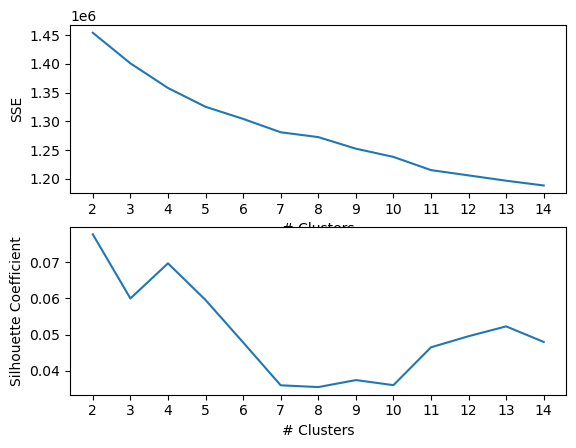

In [5]:
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coeffs.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [6]:
#find elbow mathematically:
kl = KneeLocator(
    range(2, tryks), sse, curve="convex", direction="decreasing"
)

kelbow = kl.elbow
print(kelbow)

7


In [7]:
#find max cluster number mathematically
maxsc = max(silhouette_coeffs)
katmaxsc = silhouette_coeffs.index(maxsc)+2
print(katmaxsc)

2


Do these clusters correspond with any emotions?

In [8]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

labels['elbow'] = elbowclusters
labels['silhouette'] = silclusters
print(labels)

     emotion  elbow  silhouette
0        ANG      4           1
1        SAD      3           1
2        ANG      0           0
3        SAD      5           1
4        ANG      0           0
...      ...    ...         ...
2528     HAP      1           1
2529     HAP      6           0
2530     SAD      5           1
2531     HAP      6           0
2532     HAP      1           1

[2533 rows x 3 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_8944\2770014292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow'] = elbowclusters
C:\Users\USER\AppData\Local\Temp\ipykernel_8944\2770014292.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette'] = silclusters


In [9]:
#now compare
emottotals = labels.groupby('emotion').size().reset_index(name='emottotals')

grouped0 = labels.groupby(['emotion', 'elbow']).size().reset_index(name='count')
grouped1 = labels.groupby(['emotion', 'silhouette']).size().reset_index(name='count')

merged0 = pd.merge(grouped0, emottotals, on='emotion')
merged0['percentage'] = (merged0['count'] / merged0['emottotals']) * 100

merged1 = pd.merge(grouped1, emottotals, on='emotion')
merged1['percentage'] = (merged1['count'] / merged1['emottotals']) * 100

print(merged1)

  emotion  silhouette  count  emottotals  percentage
0     ANG           0    482         887   54.340474
1     ANG           1    405         887   45.659526
2     HAP           0    418         832   50.240385
3     HAP           1    414         832   49.759615
4     SAD           0    405         814   49.754300
5     SAD           1    409         814   50.245700


With 2 groups, there is no differentiation between the emotions

In [10]:
print(merged0)

   emotion  elbow  count  emottotals  percentage
0      ANG      0    326         887   36.753100
1      ANG      1    198         887   22.322435
2      ANG      2      7         887    0.789177
3      ANG      3      1         887    0.112740
4      ANG      4    208         887   23.449831
5      ANG      5      1         887    0.112740
6      ANG      6    146         887   16.459977
7      HAP      0    223         832   26.802885
8      HAP      1    202         832   24.278846
9      HAP      2      9         832    1.081731
10     HAP      3      1         832    0.120192
11     HAP      4      6         832    0.721154
12     HAP      5    203         832   24.399038
13     HAP      6    188         832   22.596154
14     SAD      0     64         814    7.862408
15     SAD      1      1         814    0.122850
16     SAD      2     18         814    2.211302
17     SAD      3    201         814   24.692875
18     SAD      4      2         814    0.245700
19     SAD      5   

With more groups, there is some differentiation. Let's get a better look.

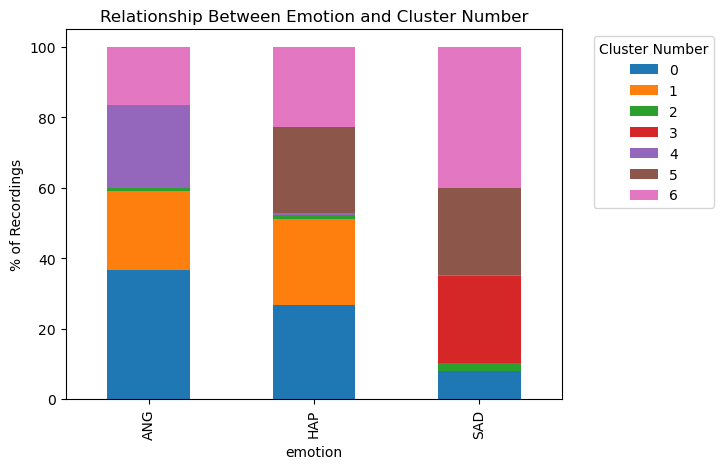

In [11]:
merged0['count'] = merged0['count'].astype(int) #avoid float error
merged0['elbow'] = merged0['elbow'].astype(str) #avoid float error

plotdf = merged0.pivot(index='emotion', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Do these clusters correspond with any languages?

In [12]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

langdata['elbow'] = elbowclusters
langdata['silhouette'] = silclusters
print(langdata)

     language  elbow  silhouette
0         ENG      0           0
1         ENG      3           0
2         ITA      4           1
3         ENG      6           0
4         ITA      4           1
...       ...    ...         ...
2528      ENG      1           0
2529      EST      2           1
2530      ENG      6           0
2531      GER      2           1
2532      ENG      1           0

[2533 rows x 3 columns]


In [13]:
#now compare
langtotals = langdata.groupby('language').size().reset_index(name='langtotals')

groupedl0 = langdata.groupby(['language', 'elbow']).size().reset_index(name='count')
groupedl1 = langdata.groupby(['language', 'silhouette']).size().reset_index(name='count')

mergedl0 = pd.merge(groupedl0, langtotals, on='language')
mergedl0['percentage'] = (mergedl0['count'] / mergedl0['langtotals']) * 100

mergedl1 = pd.merge(groupedl1, langtotals, on='language')
mergedl1['percentage'] = (mergedl1['count'] / mergedl1['langtotals']) * 100

print(mergedl1)

  language  silhouette  count  langtotals  percentage
0      ENG           0   1199        1199  100.000000
1      EST           0      6         386    1.554404
2      EST           1    380         386   98.445596
3      FRE           0     14         108   12.962963
4      FRE           1     94         108   87.037037
5      GER           0      1         260    0.384615
6      GER           1    259         260   99.615385
7      GRE           1    362         362  100.000000
8      ITA           0      8         218    3.669725
9      ITA           1    210         218   96.330275


With 2 clusters, there does seem to be a difference between the languages.

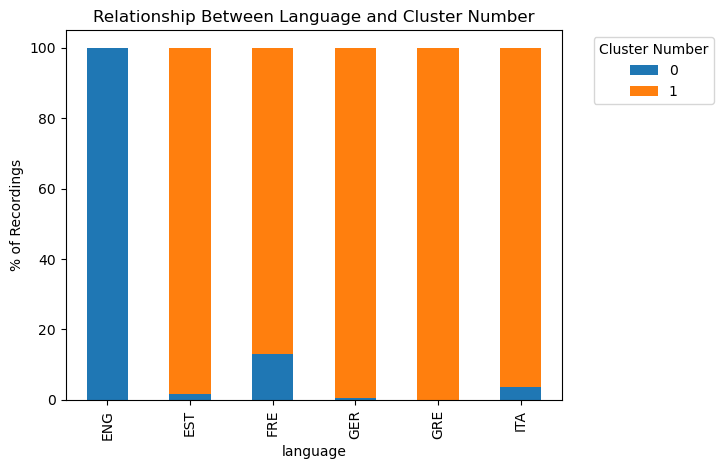

In [14]:
mergedl1['count'] = mergedl1['count'].astype(int) #avoid float error
mergedl1['silhoutte'] = mergedl1['silhouette'].astype(str) #avoid float error

plotdf = mergedl1.pivot(index='language', columns='silhouette', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [15]:
print(mergedl0)

   language  elbow  count  langtotals  percentage
0       ENG      0    199        1199   16.597164
1       ENG      1    196        1199   16.346956
2       ENG      3    200        1199   16.680567
3       ENG      5    203        1199   16.930776
4       ENG      6    401        1199   33.444537
5       EST      0      9         386    2.331606
6       EST      2    375         386   97.150259
7       EST      4      2         386    0.518135
8       FRE      0      2         108    1.851852
9       FRE      2      6         108    5.555556
10      FRE      3      1         108    0.925926
11      FRE      4     94         108   87.037037
12      FRE      5      1         108    0.925926
13      FRE      6      4         108    3.703704
14      GER      0      3         260    1.153846
15      GER      1      1         260    0.384615
16      GER      2     71         260   27.307692
17      GER      4    185         260   71.153846
18      GRE      2    119         362   32.872928


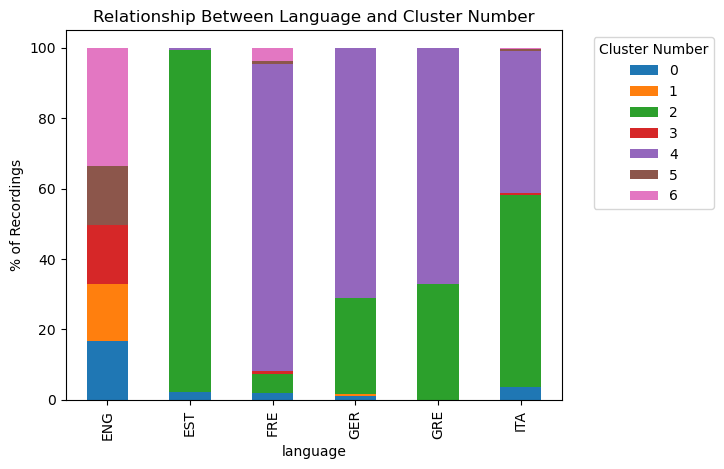

In [16]:
mergedl0['count'] = mergedl0['count'].astype(int) #avoid float error
mergedl0['elbow'] = mergedl0['elbow'].astype(str) #avoid float error

plotdf = mergedl0.pivot(index='language', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

There is a clear separation between languages. Honestly, since there is a column for each lanuage one-hot encoded, it actually has everything it needs to separate them out nicely. What happens if we redo this, but remove that information?

# Without Language Data

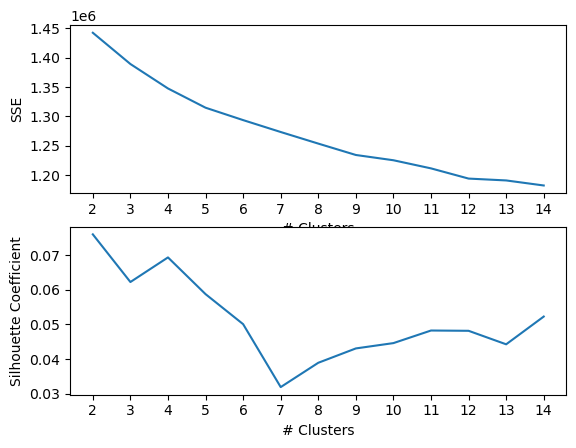

In [17]:
df2 = pd.get_dummies(dfin, columns=['gender'])
#drop the empty column at the beginning
df2 = df2.drop('Unnamed: 0',axis = 1)

#remove categorical columns except the column of interest, one gender. Remove language.
droplist= ['file_name', 'gender_M', 'sample_rate', 'bit_depth', 'language'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df2 = df2.drop(droplist, axis=1)
features2 = df2.drop(labcol, axis=1)
#Center and Scale
scaled_features2 = scaler.fit_transform(features2)

#make model for our input
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse2 = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs2 = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features2)
    sse2.append(kmeans.inertia_)
    score = silhouette_score(scaled_features2, kmeans.labels_)
    silhouette_coeffs2.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()



In [18]:
#find elbow mathematically:
kl2 = KneeLocator(
    range(2, tryks), sse2, curve="convex", direction="decreasing"
)
kelbow2 = kl2.elbow

#find max cluster number mathematically
maxsc2 = max(silhouette_coeffs2)
katmaxsc2 = silhouette_coeffs2.index(maxsc2)+2

Look for correlations with emotions

In [19]:
#Run with k from elbow method:
kmeanselbow2 = KMeans(n_clusters=kelbow2, **kmeans_kwargs)
elbowclusters2 = kmeanselbow2.fit_predict(scaled_features2)
#Run with k from silhouette coeffs method:
kmeanssil2 = KMeans(n_clusters=katmaxsc2, **kmeans_kwargs)
silclusters2 = kmeanssil2.fit_predict(scaled_features2)

labels['elbow2'] = elbowclusters2
labels['silhouette2'] = silclusters2
print(labels)

     emotion  elbow  silhouette  elbow2  silhouette2
0        ANG      4           1       4            1
1        SAD      3           1       0            1
2        ANG      0           0       3            0
3        SAD      5           1       0            1
4        ANG      0           0       3            0
...      ...    ...         ...     ...          ...
2528     HAP      1           1       1            1
2529     HAP      6           0       2            0
2530     SAD      5           1       0            1
2531     HAP      6           0       2            0
2532     HAP      1           1       1            1

[2533 rows x 5 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_8944\1174464912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow2'] = elbowclusters2
C:\Users\USER\AppData\Local\Temp\ipykernel_8944\1174464912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette2'] = silclusters2


In [20]:
grouped02 = labels.groupby(['emotion', 'elbow2']).size().reset_index(name='count')
grouped12 = labels.groupby(['emotion', 'silhouette2']).size().reset_index(name='count')

merged02 = pd.merge(grouped02, emottotals, on='emotion')
merged02['percentage2'] = (merged02['count'] / merged02['emottotals']) * 100

merged12 = pd.merge(grouped12, emottotals, on='emotion')
merged12['percentage'] = (merged12['count'] / merged12['emottotals']) * 100

print(merged12)
print(merged02)

  emotion  silhouette2  count  emottotals  percentage
0     ANG            0    481         887   54.227734
1     ANG            1    406         887   45.772266
2     HAP            0    414         832   49.759615
3     HAP            1    418         832   50.240385
4     SAD            0    402         814   49.385749
5     SAD            1    412         814   50.614251
   emotion  elbow2  count  emottotals  percentage2
0      ANG       0      2         887     0.225479
1      ANG       1    199         887    22.435175
2      ANG       2    153         887    17.249154
3      ANG       3    322         887    36.302142
4      ANG       4    211         887    23.788050
5      HAP       0    203         832    24.399038
6      HAP       1    202         832    24.278846
7      HAP       2    201         832    24.158654
8      HAP       3    218         832    26.201923
9      HAP       4      8         832     0.961538
10     SAD       0    400         814    49.140049
11     SAD

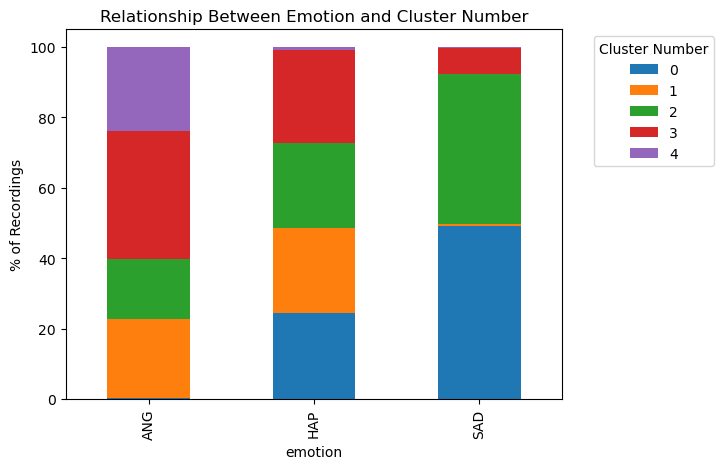

In [23]:
merged02['count'] = merged02['count'].astype(int) #avoid float error
merged02['elbow2'] = merged02['elbow2'].astype(str) #avoid float error

plotdf2 = merged02.pivot(index='emotion', columns='elbow2', values='percentage2').fillna(0)

plotdf2.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Find important features

In [26]:
#Add the cluster number to the original data
features2['kcluster'] = elbowclusters2
# Calculate centroids
centroids = features2.groupby('kcluster').mean()
print(centroids)


          duration  syllabic_rate  zcr_mean   zcr_std  zcr_frequncy  \
kcluster                                                              
0         2.205193       0.459982  0.115461  0.171235      0.459982   
1         1.942093       0.519676  0.200808  0.227886      0.519676   
2         3.486625       0.378535  0.084669  0.082306      0.374000   
3         2.829681       0.396476  0.144345  0.114436      0.396476   
4         1.426650       0.728699  0.099252  0.099701      0.728699   

          mean_spectral_envelope  median_spectral_envelope  \
kcluster                                                     
0                    2227.141449               1492.398700   
1                    3248.173428               2505.883572   
2                    1841.480675               1435.922388   
3                    2566.733132               2182.602539   
4                    2196.006180               1780.998758   

          min_spectral_envelope  max_spectral_envelope  std_spectra

In [39]:
#Use ANOVA to find the important features
anova_results = {}
for feature in features2.columns[:-1]:  # exclude the 'Cluster' column
    groups = [features2[features2['kcluster'] == cluster][feature] for cluster in features2['kcluster'].unique()]
    anova_results[feature] = f_oneway(*groups)

#We have so many tests. Do a Bonferroni correction
num_tests = len(anova_results)
p_values = [anova_results[feature].pvalue for feature in anova_results]
corrected_p_values = np.minimum(np.array(p_values) * num_tests, 1.0)  # Bonferroni correction


# Display the results
anova_results_df = pd.DataFrame(anova_results, index=['F-Statistic', 'P-Value']).T
anova_results_df['Bonf Ps'] = corrected_p_values
print(anova_results_df.sort_values(by='Bonf Ps'))

C:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


                                     F-Statistic  P-Value  Bonf Ps
meancent                              739.619737      0.0      0.0
zcr_stds_diffs_0_1                   1936.725370      0.0      0.0
mfccs_mean_4                          568.372893      0.0      0.0
zcr_diffs_from_average0_1            3270.471115      0.0      0.0
meancent_short_2                      701.727421      0.0      0.0
...                                          ...      ...      ...
frequncys_zcr_diff                           NaN      NaN      NaN
zcr_frequncys_diffs_from_average0_1          NaN      NaN      NaN
zcr_frequncys_diffs_from_average1_2          NaN      NaN      NaN
zcr_frequncys_diffs_from_average2_3          NaN      NaN      NaN
zcr_frequncys_diffs_from_average3_4          NaN      NaN      NaN

[619 rows x 3 columns]


In [43]:
anova_results_df.sort_values(by='Bonf Ps')[480:500]

,F-Statistic,P-Value,Bonf Ps
maxf_items_short_3_grad,9.703774,8.688811e-08,0.000054
maxf_items_short/maxf_items_short_3_grad,9.703774,8.688811e-08,0.000054
f0_short_1_grad,9.641690,9.760329e-08,0.000060
maxptf_short/meancent_short_1_grad,9.280554,1.918729e-07,0.000119
syllabic_rate_diffs_0_1,9.177676,2.325754e-07,0.000144
syllabic_rate_diffs_1_2,9.162494,2.392711e-07,0.000148
maxpf_short_1_diff,9.060172,2.897001e-07,0.000179
chroma05_3_grad,9.038218,3.018316e-07,0.000187
magmax_short_1_grad,9.028301,3.074768e-07,0.000190
maxptf_short_2_diff,8.740529,5.262339e-07,0.000326


Even with the Bonferroni adjustment and setting a low threshold, there are still a lot of "statistically significant" features between the groups.
Let's just look at the top 20 to get an idea of what is likely to be important.

In [44]:
anova_results_df.sort_values(by='Bonf Ps')[0:20]

,F-Statistic,P-Value,Bonf Ps
meancent,739.619737,0.0,0.0
zcr_stds_diffs_0_1,1936.725370,0.0,0.0
mfccs_mean_4,568.372893,0.0,0.0
zcr_diffs_from_average0_1,3270.471115,0.0,0.0
meancent_short_2,701.727421,0.0,0.0
zcr_from_average2,815.962961,0.0,0.0
zcr_from_average1,689.806827,0.0,0.0
zcr_from_average0,3812.005464,0.0,0.0
mean_zcr_diff,1418.833979,0.0,0.0
mfccs_mean_11,653.128829,0.0,0.0
